In [1]:
# import os
# os.environ["TRITON_INTERPRET"] = "1"

In [8]:
import torch
from model_triton import t_tlayer_ffn_fwd, t_gelu_fwd_

BS, N, D = 8, 512, 768
FFN = 4 * D
aa = torch.randn((BS, N, D), device="cuda")
p0 = torch.randn((FFN, D), device="cuda")
p1 = torch.randn((FFN,), device="cuda")
p2 = torch.randn((D, FFN), device="cuda")
p3 = torch.randn((D,), device="cuda")
params = (p0, p1, p2, p3)
N_RUNS = 10

def fn_naive(x):
    return t_tlayer_ffn_fwd(params, x, t_gelu_fwd_)
fn_jit = torch.compile(fn_naive)
# burn it
fn_jit(aa) 
#fn_jit(dloss_dx, aa) 
#fn_jit(aa, bb) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N_RUNS):
        result = fn_jit(aa)
        #result = fn_jit(dloss_dx, aa)
        #result = fn_jit(aa, bb)
        
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N_RUNS):
    result = fn_jit(aa)
    #result = fn_jit(dloss_dx, aa)
    #result = fn_jit(aa, bb)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N_RUNS):
    result = fn_naive(aa)
    #result = fn_naive(dloss_dx, aa)
    #result = fn_naive(aa, bb)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Torch-Compiled Region: 2/0        14.63%       2.649ms        19.53%       3.536ms     353.617us       0.000us         0.00%      16.520ms       1.652ms            10  
                                               aten::mm         2.42%     438.667us         3.24%     585.799us      29.290us      13.922ms        84.28%      13.922ms     696.120us            20  
void cutl

In [ ]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [ ]:
torch.backends.cuda.matmul.allow_tf32

In [9]:
import triton
import triton.language as tl

from model_triton import gelu_k

# This is an incomplete implementation. It makes the assumption that n_programs  
# and m_programs are disiable by GROUP_SIZE_M
# Assumes allow_tf32 (i.e. torch.backends.cuda.matmul.allow_tf32) being True 
# Note I overload this function by adding logic for linear layer in it
@triton.jit
def t_matmul_k(a_ptr, b_ptr, output_ptr, bias_ptr,
                a_row_stride, a_col_stride,
                b_row_stride, b_col_stride,
                output_row_stride, output_col_stride,
                n, m, k,
                ADD_BIAS: tl.constexpr, ACTIVATION: tl.constexpr, # Overloading matmul with params for linear layer
                BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
                GROUP_SIZE_M: tl.constexpr,
                ):
    # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
    ASM: tl.constexpr = "cvt.rna.tf32.f32 $0, $1;"
        
    pid = tl.program_id(0)
    n_programs = tl.cdiv(n, BLOCK_SIZE_N)
    m_programs = tl.cdiv(m, BLOCK_SIZE_M)
    orig_n_pid = pid // m_programs
    orig_m_pid = pid % m_programs
       
    # TODO T: Fix bug in Grouping to improve L2 Cache hit rate
    # TODO T: simplify the grp_id calculations. Expand if m_programs are not divisable by GROUP_SIZE_M
    # m_groups = m_programs // GROUP_SIZE_M # assumes m_programs is divisable by GROUP_SIZE_M for now
    # n_grp_id = orig_n_pid % (n_programs//m_groups) # assumes n_programs is divisable by GROUP_SIZE_M for now
    # m_grp_id = (orig_n_pid * m_groups)//n_programs
    # n_pid =  n_grp_id * m_groups + orig_m_pid // GROUP_SIZE_M
    # m_pid =  m_grp_id * GROUP_SIZE_M + orig_m_pid % GROUP_SIZE_M
    n_pid = orig_n_pid
    m_pid = orig_m_pid 
    
    offsets = tl.arange(0, BLOCK_SIZE_K)     
    n_offsets = n_pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    m_offsets = m_pid * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    # TODO T: Do I need modulo n, modulo m operations?    
    n_offsets_mod = n_offsets %n
    m_offsets_mod = m_offsets %m
    
    acc = tl.zeros((BLOCK_SIZE_N, BLOCK_SIZE_M), dtype=tl.float32)
    for i in range(0, tl.cdiv(k, BLOCK_SIZE_K)):
        k_step_offsets = i*BLOCK_SIZE_K + offsets
        a_blck_ptr = a_ptr + n_offsets_mod[:,None] * a_row_stride + k_step_offsets[None, :] * a_col_stride
        a_blck = tl.load(a_blck_ptr, mask=k_step_offsets[None, :] < k, other=0.0) 
        b_blck_ptr = b_ptr + k_step_offsets[:,None] * b_row_stride + m_offsets_mod[None, :] * b_col_stride
        b_blck = tl.load(b_blck_ptr, mask=k_step_offsets[:, None] < k, other=0.0)

        # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
        a_blck = tl.inline_asm_elementwise(ASM, "=r, r", [a_blck], dtype=tl.float32, is_pure=True, pack=1)
        b_blck = tl.inline_asm_elementwise(ASM, "=r, r", [b_blck], dtype=tl.float32, is_pure=True, pack=1)
        
        # To test for double precision (https://github.com/triton-lang/triton/issues/4603)
        # Use tf32x3 (slow) below without ASM elementwise casts above 
        acc = tl.dot(a_blck, b_blck, acc) #, input_precision="tf32x3")
    if ADD_BIAS:
        bias = tl.load(bias_ptr + m_offsets, mask=m_offsets<m, other=0.0)
        acc += bias # Works since Triton's broadcasting follows one of Numpy
    if ACTIVATION == "gelu":
        acc = gelu_k(acc)
    output_blck_ptr = output_ptr + n_offsets[:,None] * output_row_stride + m_offsets[None, :] * output_col_stride
    output_mask = (n_offsets[:,None] <n) & (m_offsets[None, :]<m)
    tl.store(output_blck_ptr, acc, mask=output_mask)

from model_triton import t_gelu_fwd
def t_tlayer_ffn_fwd_t(layer_params, x:torch.Tensor, activation_fn):
    assert activation_fn == t_gelu_fwd
    
    # FFN1
    output_dim = x.shape
    x = x.view((-1,x.shape[-1]))
    N, K = x.shape
    p0 = layer_params[0].t()
    K2, M = p0.shape
    assert K==K2
    assert x.is_contiguous(), "Matrix A must be contiguous" # TODO T: why do I need contiguous a?
    mid_output = torch.empty((N, M), device=x.device)
    grid = lambda META: (triton.cdiv(N, META['BLOCK_SIZE_N']) * triton.cdiv(M, META['BLOCK_SIZE_M']), )

    # One needs to tune params below depending on the size of input tensors 
    BLOCK_SIZE_N = 128    
    BLOCK_SIZE_M = 64
    BLOCK_SIZE_K = 32
    GROUP_SIZE_M = 8
    num_stages = 3
    num_warps = 8
    assert triton.cdiv(N, BLOCK_SIZE_N) % GROUP_SIZE_M == 0, "Limtation of implementation" # TODO T: Complete implementation
    assert triton.cdiv(M, BLOCK_SIZE_M) % GROUP_SIZE_M == 0, "Limtation of implementation" # TODO T: Complete implementation

    t_matmul_k[grid](
        x, p0, mid_output, layer_params[1], 
        x.stride(0), x.stride(1), p0.stride(0), p0.stride(1), mid_output.stride(0), mid_output.stride(1), 
        N, M, K, ADD_BIAS=True, ACTIVATION = "gelu", 
        BLOCK_SIZE_N=BLOCK_SIZE_N, BLOCK_SIZE_M=BLOCK_SIZE_M, BLOCK_SIZE_K=BLOCK_SIZE_K, 
        GROUP_SIZE_M=GROUP_SIZE_M, num_stages=num_stages, num_warps=num_warps)

    # FFN2: Note the swap of dimensions (K and M)
    p2 = layer_params[2].t()
    assert mid_output.is_contiguous(), "Matrix A must be contiguous" # TODO T: why do I need contiguous a?
    output = torch.empty((N, K), device=x.device) 
    
    # One needs to tune params below depending on the size of input tensors 
    BLOCK_SIZE_N = 128    
    BLOCK_SIZE_M = 64
    BLOCK_SIZE_K = 32
    GROUP_SIZE_M = 4 # TODO T: Bump up once we fix grouping?
    num_stages = 3
    num_warps = 8
    assert triton.cdiv(N, BLOCK_SIZE_N) % GROUP_SIZE_M == 0, "Limtation of implementation" # TODO T: Complete implementation
    assert triton.cdiv(K, BLOCK_SIZE_M) % GROUP_SIZE_M == 0, "Limtation of implementation" # TODO T: Complete implementation

    
    t_matmul_k[grid](
        mid_output, p2, output, layer_params[3],
        mid_output.stride(0), mid_output.stride(1), p2.stride(0), p2.stride(1), output.stride(0), output.stride(1), 
        N, K, M, ADD_BIAS=True, ACTIVATION = None, 
        BLOCK_SIZE_N=BLOCK_SIZE_N, BLOCK_SIZE_M=BLOCK_SIZE_M, BLOCK_SIZE_K=BLOCK_SIZE_K, 
        GROUP_SIZE_M=GROUP_SIZE_M, num_stages=num_stages, num_warps=num_warps)
    
    
    return output.view(output_dim)

params_t = (params[0].t(), params[1], params[2].t(), params[3])
def fn_t(x):
    return t_tlayer_ffn_fwd_t(params, x, t_gelu_fwd)

# from torch.profiler import profile, record_function, ProfilerActivity, schedule
# activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
# with profile(activities=activities, record_shapes=True) as prof:
#     for _ in range(N):
#         #result = fn_t(aa)
#         #result = fn_t(dloss_dx, aa)
#         result = fn_t(aa, bb)
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

fn_t(aa)

import time
t0 = time.time()
for _ in range(N_RUNS):
    result = fn_t(aa)
    #result = fn_t(dloss_dx, aa)
#    result = fn_t(aa, bb)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

total 0.033469438552856445


In [11]:

# allow_tf32_saved = torch.backends.cuda.matmul.allow_tf32
# torch.backends.cuda.matmul.allow_tf32 = False
# d_ref = torch.mm(aa.to(torch.double), bb.to(torch.double))
# torch.backends.cuda.matmul.allow_tf32 = allow_tf32_saved

res1 = fn_jit(aa)
#res1 = fn_jit(dloss_dx, aa)
#res1 = fn_jit(aa, bb)
res2 = fn_t(aa)
#res2 = fn_t(dloss_dx, aa)
#res2 = fn_t(aa, bb)

#print(f'd_ref', d_ref[:4, :4])
print(f'res1', res1.shape, res1[:4, :4])
print(f'res2', res2.shape, res2[:4, :4])
print(f'---')
#print(f'd_ref', d_ref[-4:, -4:])
print(f'res1', res1[-4:, -4:])
print(f'res2', res2[-4:, -4:])
print(f'------')
#print('aa', aa)
#print('bb', bb)
#print(f'aa[0] * b[:,0]', aa[0] * bb[:,0])
#assert torch.allclose(res1, res2, atol=1e-2)
assert torch.allclose(res1, res2, atol=1.7e-2, rtol=0), (res1.shape, res2.shape, res1[-4:, -4:], res2[-4:, -4:])
#assert torch.allclose(res1, res2), (res1.shape, res2.shape, res1[0:4, 0:4], res2[0:4, 0:4])
print(f'res1', res1[-4:, -4:])
print(f'res2', res2[-4:, -4:])

print(res2)

res1 torch.Size([8, 512, 768]) tensor([[[-2044.2085,  -628.0964,   509.8030,  ...,  2506.4290,
           1714.4983,   438.8811],
         [  619.1483,   970.4095,  -213.6661,  ...,  -597.3315,
            349.2857,  -900.2518],
         [  -33.1344,  -572.9765, -1567.0997,  ...,   282.1264,
           -141.3630,  -224.8687],
         [  138.4579,  1366.9819,  -797.5416,  ...,  1850.9603,
           -351.1953,   189.9967]],

        [[-1056.1564,  -259.5440,  -617.0130,  ...,  -978.8630,
           2527.1841,  2615.4475],
         [ 1095.5505,  -182.4461, -1122.1571,  ...,  1494.2449,
           1704.5344,   807.6739],
         [   54.2482, -1061.6094,  -250.8617,  ...,   645.6375,
            603.7654,  1200.8158],
         [  236.9339,   184.6860,   805.4480,  ...,  1364.8855,
           1491.6332,   -32.8355]],

        [[-1305.0312,    50.8062,   524.9065,  ...,   187.7160,
           1025.1987,  1229.1498],
         [ 1321.0454,  -389.5916, -2208.6802,  ...,   801.3989,
          

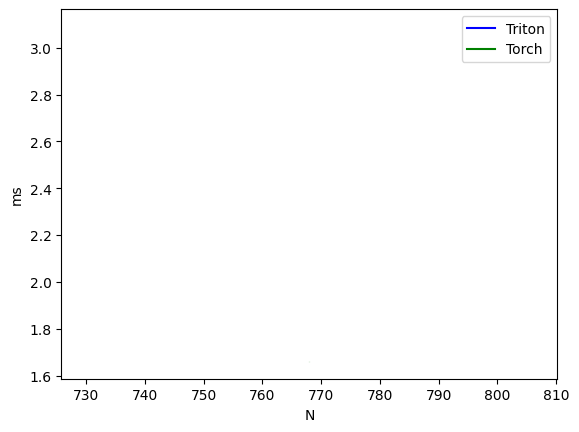

t_matmul:
       N      M      K    Triton     Torch
0  768.0  768.0  768.0  3.092352  1.659744


In [12]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N', 'M', 'K'],  # Argument names to use as an x-axis for the plot.
        x_vals=[768],
        #x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='ms',  # Label name for the y-axis.
        plot_name='t_tlayer_ffn_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(N, M, K, provider):
    #dloss_dx = torch.rand(M, N, device="cuda", dtype=torch.float32)    
    #x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    BS, N, D = 8, 512, 768
    x = torch.randn((BS, N, D), device="cuda")
#     a = torch.rand(N, K, device="cuda", dtype=torch.float32)
#     b = torch.rand(K, M, device="cuda", dtype=torch.float32)    
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(aa, bb), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    #if provider == 'naive':
    #    #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
    #    ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    #perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3) # TODO XXX: investigate whether this is right. In the tutorial they operate on different dtype
    perf = lambda ms: ms
    return perf(ms), perf(max_ms), perf(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [ ]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

In [ ]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
print(f'num_stages', num_stages, 'num_warps', num_warps)
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)

dloss_dx_2d = torch.randn_like(x_2d)
kernel = t_log_softmax_bkwd2_k.warmup(dloss_dx_2d, x_2d, output, dloss_dx_2d.stride(0), x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                    num_stages=num_stages, num_warps=num_warps, grid=(1, ))
#kernel = t_log_softmax_fwd_k.warmup(x_2d, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
#                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

In [ ]:
32
2080
4128
6176